<a href="https://colab.research.google.com/github/rastehNili/MelanomaDetection/blob/main/rasteh_nili_nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing all the important libraries

In [ ]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from google.colab import drive

In [ ]:
## mounting the google drive:

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [ ]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/upgrad/4.DeepLearning/Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path("/content/gdrive/MyDrive/upgrad/4.DeepLearning/Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test")

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [ ]:

## train dataset
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir_train,
    seed = 123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)
train_ds

Found 7717 files belonging to 10 classes.


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir_test,
    seed = 123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)
val_ds

Found 118 files belonging to 9 classes.


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


Since classes are highly imbalanced, the models become good at predicting the majority class but perform poorly on the minority class. Regularization is important. If the model is not appropriately regularized, it may overfit the majority class, leading to a poor generalization of new data.

### Visualize the data
#### Create a code to visualize one instance of all the nine classes present in the dataset

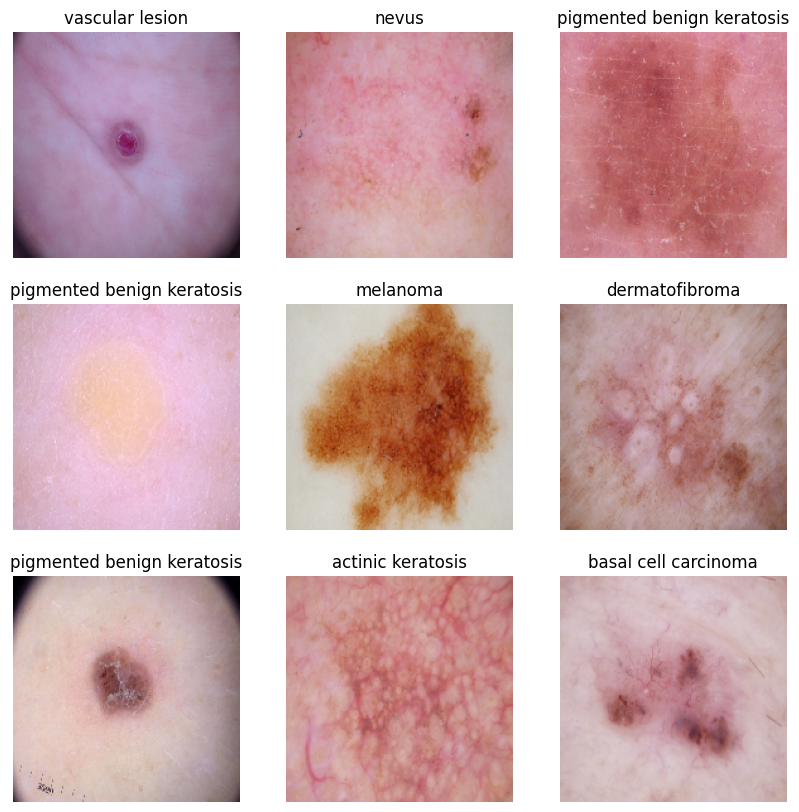

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
for image, label in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(image[i].numpy().astype("uint8"))
    plt.title(class_names[label[i]])
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [ ]:
# The pixels are originally stored as type int, but it is advisable to feed the data as float
# The number of filters is the number of neurons, since each neuron performs a different
# convolution on the input to the layer (more precisely, the neurons' input weights form
# convolution kernels).

num_classes = 9

model = Sequential([layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
                    layers.Conv2D(16, 3, padding="same", activation="relu"),
                    # we slide over the feture map and extract tiles of a specified size
                    layers.MaxPool2D(),

                    layers.Conv2D(32, 3, padding="same", activation="relu"),
                    # we slide over the feture map and extract tiles of a specified size
                    layers.MaxPool2D(),

                    layers.Conv2D(64, 3, padding="same", activation="relu"),
                    # we slide over the feture map and extract tiles of a specified size
                    layers.MaxPool2D(),

                    # Advantages of downsampling - decrease size of input for upcoming layers,
                    # works again overfiting

                    # Flattening - convert into 1D feature vector. Flattens all its structure to create a
                    # single long feature vector
                    layers.Flatten(),

                    # Fully connected Dense layer - A dense layer represents a matrix-vector multiplication.
                    # each input node is connected to each output node
                    layers.Dense(128, activation="relu"),

                    # Dense layer - A dense layer represents a matrix-vector multiplication.
                    # each input node is connected to each output node
                    layers.Dense(num_classes)
                    ])


### Compile the model
Choose an appropirate optimiser and loss function for model training

In [ ]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer="adam",
              metrics=['accuracy'])

In [ ]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Train the model

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  batch_size=batch_size,
  epochs=epochs,
  verbose=1
)

Epoch 1/20
70/70 [==============================] - 24s 214ms/step - loss: 2.0023 - accuracy: 0.2666 - val_loss: 2.4315 - val_accuracy: 0.1864
Epoch 2/20
70/70 [==============================] - 1s 8ms/step - loss: 1.6232 - accuracy: 0.4216 - val_loss: 2.2543 - val_accuracy: 0.3220
Epoch 3/20
70/70 [==============================] - 1s 8ms/step - loss: 1.4945 - accuracy: 0.4841 - val_loss: 2.0267 - val_accuracy: 0.3390
Epoch 4/20
70/70 [==============================] - 1s 8ms/step - loss: 1.3252 - accuracy: 0.5333 - val_loss: 2.4747 - val_accuracy: 0.3559
Epoch 5/20
70/70 [==============================] - 1s 8ms/step - loss: 1.2592 - accuracy: 0.5574 - val_loss: 2.5160 - val_accuracy: 0.3390
Epoch 6/20
70/70 [==============================] - 1s 8ms/step - loss: 1.2152 - accuracy: 0.5672 - val_loss: 2.4733 - val_accuracy: 0.3644
Epoch 7/20
70/70 [==============================] - 1s 8ms/step - loss: 1.1313 - accuracy: 0.5994 - val_loss: 2.2249 - val_accuracy: 0.3390
Epoch 8/20
70/70 

### Visualizing training results

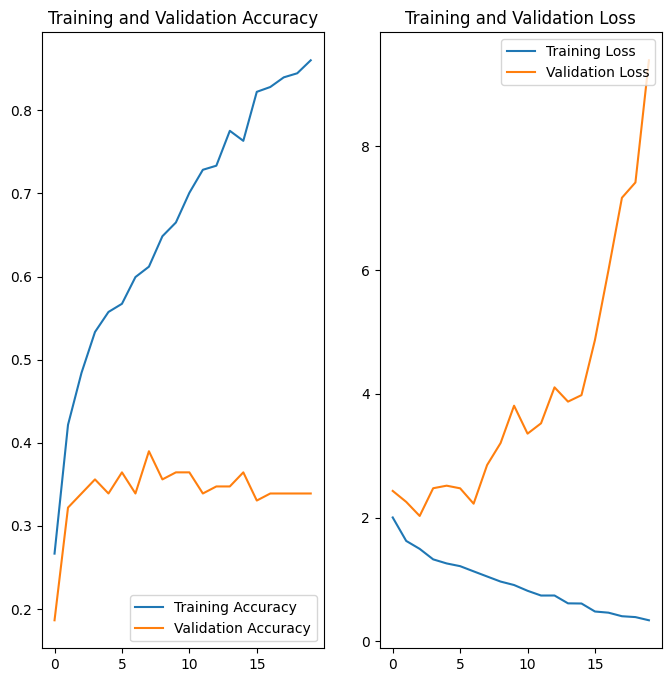

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Write your findings here
Model is showing to be overfitted since we have about 80% training accuracy while the validation accuracy is bellow 40%. the validation loss is also very high in validation set while it is getting close to zero near 20 epocs

In [ ]:
#  Increase number of neurons
um_classes = 9

model = Sequential([layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
                    layers.Conv2D(64, 3, padding="same", activation="relu"),
                    # we slide over the feture map and extract tiles of a specified size
                    layers.MaxPool2D(),

                    layers.Conv2D(128, 3, padding="same", activation="relu"),
                    # we slide over the feture map and extract tiles of a specified size
                    layers.MaxPool2D(),

                    layers.Conv2D(64, 3, padding="same", activation="relu"),
                    # we slide over the feture map and extract tiles of a specified size
                    layers.MaxPool2D(),

                    # Advantages of downsampling - decrease size of input for upcoming layers,
                    # works again overfiting

                    # Flattening - convert into 1D feature vector. Flattens all its structure to create a
                    # single long feature vector
                    layers.Flatten(),

                    # Fully connected Dense layer - A dense layer represents a matrix-vector multiplication.
                    # each input node is connected to each output node
                    layers.Dense(128, activation="relu"),

                    # Dense layer - A dense layer represents a matrix-vector multiplication.
                    # each input node is connected to each output node
                    layers.Dense(num_classes)
                    ])
# compile
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer="adam",
              metrics=['accuracy'])

# View the summary of all layers
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 64)      1792      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 90, 90, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 128)       73856     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 45, 45, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 45, 45, 64)       

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  batch_size=batch_size,
  epochs=epochs,
  verbose=1
)

Epoch 1/20
70/70 [==============================] - 5s 30ms/step - loss: 2.0017 - accuracy: 0.2573 - val_loss: 2.2675 - val_accuracy: 0.2881
Epoch 2/20
70/70 [==============================] - 1s 12ms/step - loss: 1.6374 - accuracy: 0.4185 - val_loss: 2.4150 - val_accuracy: 0.2119
Epoch 3/20
70/70 [==============================] - 1s 13ms/step - loss: 1.4845 - accuracy: 0.4859 - val_loss: 2.1291 - val_accuracy: 0.3051
Epoch 4/20
70/70 [==============================] - 1s 12ms/step - loss: 1.3548 - accuracy: 0.5208 - val_loss: 2.2291 - val_accuracy: 0.3729
Epoch 5/20
70/70 [==============================] - 1s 12ms/step - loss: 1.2729 - accuracy: 0.5605 - val_loss: 2.8013 - val_accuracy: 0.3475
Epoch 6/20
70/70 [==============================] - 1s 12ms/step - loss: 1.2050 - accuracy: 0.5583 - val_loss: 2.7299 - val_accuracy: 0.3644
Epoch 7/20
70/70 [==============================] - 1s 13ms/step - loss: 1.1233 - accuracy: 0.5927 - val_loss: 2.5899 - val_accuracy: 0.3559
Epoch 8/20
70

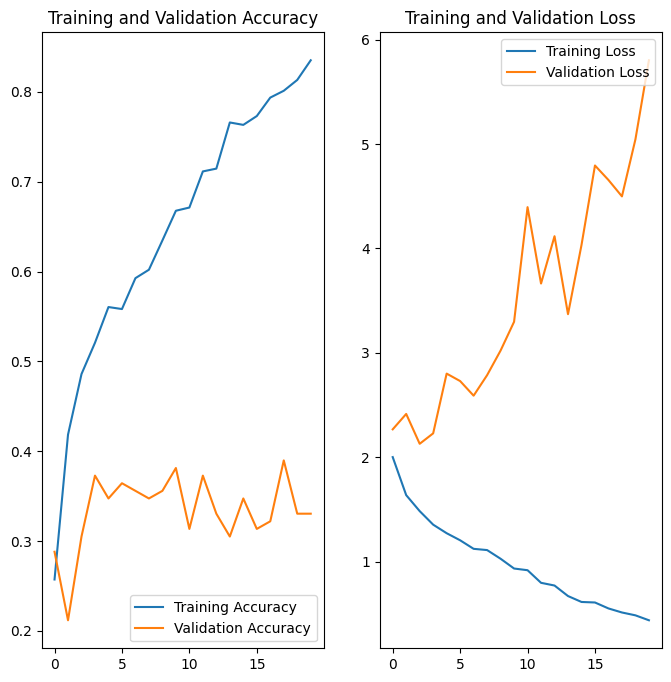

In [ ]:
# Visualise results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

increasing number of neurons decreases both training and validation accuracy

In [ ]:
# Find the number of members in each category of malenoma
# import pandas as pd
dataset_unbatched = tuple(train_ds.unbatch())
labels = []
for (image,label) in dataset_unbatched:
    labels.append(label.numpy())
labels = pd.Series(labels)

# adjustments
count = labels.value_counts().sort_index()
count.index = class_names
count

actinic keratosis             114
basal cell carcinoma          376
dermatofibroma                 95
melanoma                      438
nevus                         357
pigmented benign keratosis    462
seborrheic keratosis           77
squamous cell carcinoma       181
vascular lesion               139
dtype: int64

## **Agumentation**

Since some of the overfitting results are caused by imbalance data which can be fixed by using augmentation

In [ ]:
# choose an appropriate data augumentation strategy.
# since it is a medical image that the direction of the image is not important we can use
# random flip as augmentation method that has minimal change in image quality and is still
# preserve the required information for prediction. Also the zoom in or out would not
# have any effect on the class dependency so we can use random zoom for augmentation as well
# Your code goes here

data_augmentation = keras.Sequential([
    tf.keras.layers.RandomFlip(
        mode="horizontal_and_vertical",
        input_shape=(img_height, img_width, 3)),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1)
])


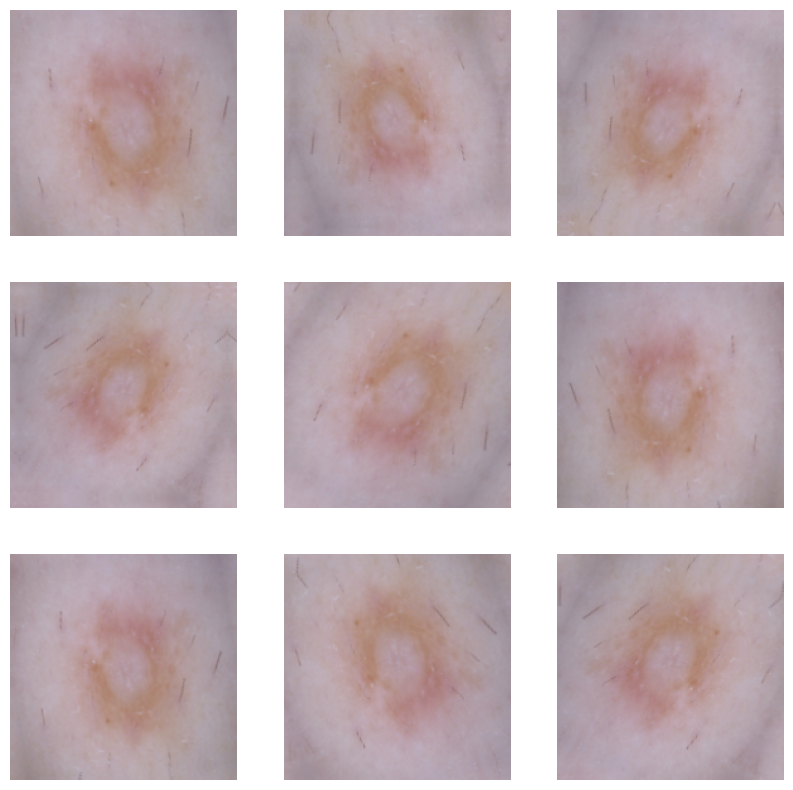

In [ ]:
# visualize how augmentation strategy works for one instance of training image.
# Your code goes here

plt.figure(figsize=(10,10))
for image, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(image)
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")



### Create the model, compile and train the model


In [ ]:
## Use Dropout layer since there is an evidence of overfitting in your findings

num_classes = 9

model= Sequential([
    data_augmentation,
    layers.experimental.preprocessing.Rescaling(1./255),
    layers.Conv2D(16, 3, padding="same", activation="relu"),
    layers.MaxPool2D(),

    layers.Conv2D(32, 3, padding="same", activation="relu"),
    layers.MaxPool2D(),

    layers.Conv2D(64, 3, padding="same", activation="relu"),
    layers.MaxPool2D(),

    # layers.Dropout(0.2),
    layers.Flatten(),

    layers.Dense(128, activation="relu"),
    layers.Dense(num_classes)
])



### Compiling the model

In [ ]:

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer="adam",
              metrics=['accuracy'])

# View the summary of all layers
model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                 

### Training the model

In [ ]:
##  train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  batch_size=batch_size,
  epochs=epochs,
  verbose=1
)

Epoch 1/20
70/70 [==============================] - 3s 11ms/step - loss: 1.9058 - accuracy: 0.2966 - val_loss: 2.0127 - val_accuracy: 0.3136
Epoch 2/20
70/70 [==============================] - 1s 9ms/step - loss: 1.5301 - accuracy: 0.4623 - val_loss: 2.2036 - val_accuracy: 0.3898
Epoch 3/20
70/70 [==============================] - 1s 9ms/step - loss: 1.4273 - accuracy: 0.5042 - val_loss: 2.4623 - val_accuracy: 0.3729
Epoch 4/20
70/70 [==============================] - 1s 9ms/step - loss: 1.3901 - accuracy: 0.5025 - val_loss: 2.2529 - val_accuracy: 0.3729
Epoch 5/20
70/70 [==============================] - 1s 9ms/step - loss: 1.3232 - accuracy: 0.5297 - val_loss: 2.5335 - val_accuracy: 0.3475
Epoch 6/20
70/70 [==============================] - 1s 9ms/step - loss: 1.2953 - accuracy: 0.5310 - val_loss: 2.5179 - val_accuracy: 0.3475
Epoch 7/20
70/70 [==============================] - 1s 9ms/step - loss: 1.2664 - accuracy: 0.5471 - val_loss: 2.4972 - val_accuracy: 0.3898
Epoch 8/20
70/70 [=

### Visualizing the results

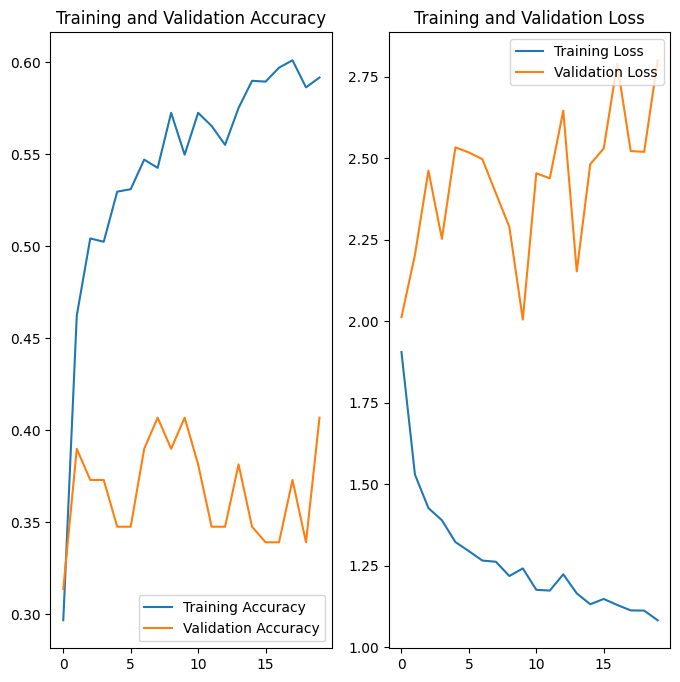

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

After balancing data the prediction quality of training set has been reduced and now the result for training and validation are closer. in the case of validation and training loss we can see even more improvements in the sense of over fitting. meaning that the training loss slightly increased but the validation loss have dramatically reduced in comparison with before augmentation.

## **Test batch normalization and dropout effects**

In [ ]:

num_classes = 9

model= Sequential([
    data_augmentation,
    layers.experimental.preprocessing.Rescaling(1./255),
    layers.Conv2D(16, 3, padding="same", activation="relu"),
    # layers.BatchNormalization(),
    layers.MaxPool2D(),
    layers.Dropout(0.2),

    layers.Conv2D(32, 3, padding="same", activation="relu"),
    # layers.BatchNormalization(),
    layers.MaxPool2D(),
    layers.Dropout(0.2),

    layers.Conv2D(64, 3, padding="same", activation="relu"),
    # layers.BatchNormalization(),
    layers.MaxPool2D(),
    layers.Dropout(0.2),

    layers.Flatten(),

    layers.Dense(128, activation="relu"),

    #  since our problem is multiclass classification we use softmax as our activation function in th elast layer
    layers.Dense(num_classes, activation="softmax")
])

## Your code goes here
# compile
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer="adam",
              metrics=['accuracy'])

# View the summary of all layers
model.summary()


Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_14 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_42 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_42 (MaxPooli  (None, 90, 90, 16)        0         
 ng2D)                                                           
                                                                 
 dropout_23 (Dropout)        (None, 90, 90, 16)        0         
                                                                 
 conv2d_43 (Conv2D)          (None, 90, 90, 32)        4640      
                                                     

In [ ]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  batch_size=batch_size,
  epochs=epochs,
  verbose=1
)

Epoch 1/20
70/70 [==============================] - 3s 13ms/step - loss: 2.3174 - accuracy: 0.2010 - val_loss: 2.1478 - val_accuracy: 0.1186
Epoch 2/20
70/70 [==============================] - 1s 10ms/step - loss: 1.9135 - accuracy: 0.3109 - val_loss: 2.1722 - val_accuracy: 0.1695
Epoch 3/20
70/70 [==============================] - 1s 10ms/step - loss: 1.6396 - accuracy: 0.4234 - val_loss: 2.0968 - val_accuracy: 0.2203
Epoch 4/20
70/70 [==============================] - 1s 10ms/step - loss: 1.4789 - accuracy: 0.4815 - val_loss: 2.1277 - val_accuracy: 0.2712
Epoch 5/20
70/70 [==============================] - 1s 10ms/step - loss: 1.4955 - accuracy: 0.4792 - val_loss: 2.1044 - val_accuracy: 0.2881
Epoch 6/20
70/70 [==============================] - 1s 10ms/step - loss: 1.3907 - accuracy: 0.5159 - val_loss: 1.8762 - val_accuracy: 0.3559
Epoch 7/20
70/70 [==============================] - 1s 10ms/step - loss: 1.3148 - accuracy: 0.5208 - val_loss: 2.2774 - val_accuracy: 0.3559
Epoch 8/20
70

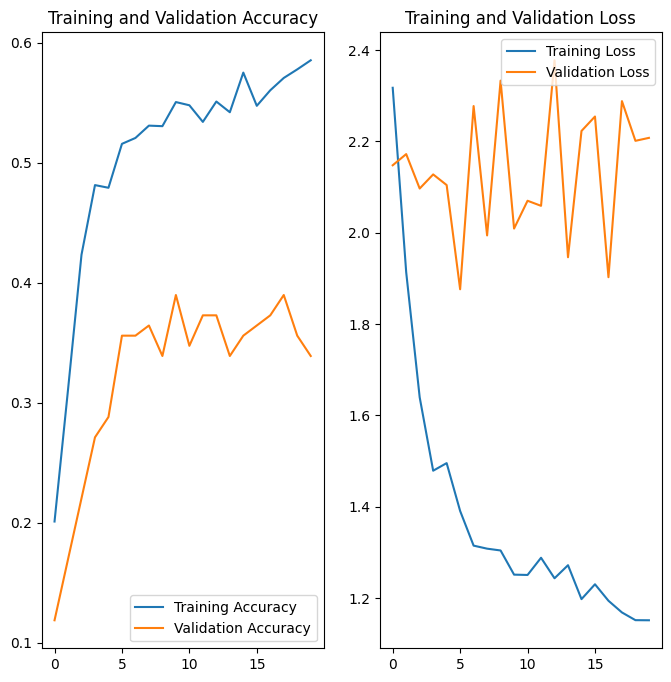

In [ ]:
#  Visualised the results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

After trying different combination of batch normalization and drop out I have found that one drop out after all maxpool layers has the highest impact in model performance after augmentation. Adding dropout slightly reduced the performance of the training set. So results for training and test sets become closer. that indicates that presence of dropout reduces the problem of overfitting.  

It also seems that after scaling batch normalization is not required.

## **Adding more layers to see if it improves model performance**

In [ ]:

num_classes = 9

model= Sequential([
    data_augmentation,
    layers.experimental.preprocessing.Rescaling(1./255),
    layers.Conv2D(16, 3, padding="same", activation="relu"),
    # layers.BatchNormalization(),
    layers.MaxPool2D(),
    layers.Dropout(0.2),

    layers.Conv2D(32, 3, padding="same", activation="relu"),
    # layers.BatchNormalization(),
    layers.MaxPool2D(),
    layers.Dropout(0.2),

    layers.Conv2D(64, 3, padding="same", activation="relu"),
    # layers.BatchNormalization(),
    layers.MaxPool2D(),
    layers.Dropout(0.2),

    layers.Conv2D(64, 3, padding="same", activation="relu"),
    # layers.BatchNormalization(),
    layers.MaxPool2D(),
    layers.Dropout(0.2),

    layers.Flatten(),

    layers.Dense(128, activation="relu"),

    #  since our problem is multiclass classification we use softmax as our activation function in th elast layer
    layers.Dense(num_classes, activation="softmax")
])

## Your code goes here
# compile
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer="adam",
              metrics=['accuracy'])

# View the summary of all layers
model.summary()


Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_27 (Sequential)  (None, 180, 180, 3)       0         
                                                                 
 rescaling_28 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_86 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_86 (MaxPooli  (None, 90, 90, 16)        0         
 ng2D)                                                           
                                                                 
 dropout_67 (Dropout)        (None, 90, 90, 16)        0         
                                                                 
 conv2d_87 (Conv2D)          (None, 90, 90, 32)        4640      
                                                     

In [ ]:
## train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  batch_size=batch_size,
  epochs=epochs,
  verbose=1
)

Epoch 1/20
242/242 [==============================] - 23s 83ms/step - loss: nan - accuracy: 0.0146 - val_loss: nan - val_accuracy: 0.1356
Epoch 2/20
242/242 [==============================] - 21s 83ms/step - loss: nan - accuracy: 0.0148 - val_loss: nan - val_accuracy: 0.1356
Epoch 3/20
242/242 [==============================] - 21s 82ms/step - loss: nan - accuracy: 0.0148 - val_loss: nan - val_accuracy: 0.1356
Epoch 4/20
242/242 [==============================] - 21s 82ms/step - loss: nan - accuracy: 0.0148 - val_loss: nan - val_accuracy: 0.1356
Epoch 5/20
242/242 [==============================] - 20s 82ms/step - loss: nan - accuracy: 0.0148 - val_loss: nan - val_accuracy: 0.1356
Epoch 6/20
242/242 [==============================] - 21s 82ms/step - loss: nan - accuracy: 0.0148 - val_loss: nan - val_accuracy: 0.1356
Epoch 7/20
242/242 [==============================] - 21s 82ms/step - loss: nan - accuracy: 0.0148 - val_loss: nan - val_accuracy: 0.1356
Epoch 8/20
242/242 [==============

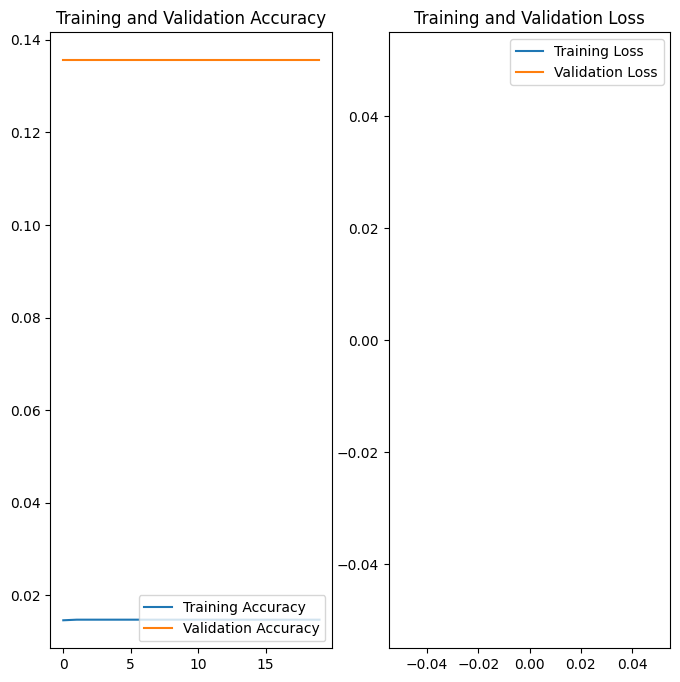

In [ ]:
#  Visualised the results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

adding more layers to the model causes a failure of model for both training nad validation set.

## **Investigate how large number of augmented data would affect model performance**

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [ ]:
from glob import glob

path_list = [x for x in glob(os.path.join(data_dir_train, "*", "*.jpg"))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, "*", "*.jpg"))]
len(path_list)

2239

In [ ]:
dataframe_dict = dict(zip(path_list, lesion_list))
df = pd.DataFrame(list(dataframe_dict.items()), columns= ["Path", "Label"])
df

,Path,Label
0,/content/gdrive/MyDrive/upgrad/4.DeepLearning/...,melanoma
1,/content/gdrive/MyDrive/upgrad/4.DeepLearning/...,melanoma
2,/content/gdrive/MyDrive/upgrad/4.DeepLearning/...,melanoma
3,/content/gdrive/MyDrive/upgrad/4.DeepLearning/...,melanoma
4,/content/gdrive/MyDrive/upgrad/4.DeepLearning/...,melanoma
...,...,...
2234,/content/gdrive/MyDrive/upgrad/4.DeepLearning/...,dermatofibroma
2235,/content/gdrive/MyDrive/upgrad/4.DeepLearning/...,dermatofibroma
2236,/content/gdrive/MyDrive/upgrad/4.DeepLearning/...,dermatofibroma
2237,/content/gdrive/MyDrive/upgrad/4.DeepLearning/...,dermatofibroma


Class=melanoma, n=438 (19.562%)
Class=actinic keratosis, n=114 (5.092%)
Class=nevus, n=357 (15.945%)
Class=vascular lesion, n=139 (6.208%)
Class=basal cell carcinoma, n=376 (16.793%)
Class=pigmented benign keratosis, n=462 (20.634%)
Class=seborrheic keratosis, n=77 (3.439%)
Class=squamous cell carcinoma, n=181 (8.084%)
Class=dermatofibroma, n=95 (4.243%)


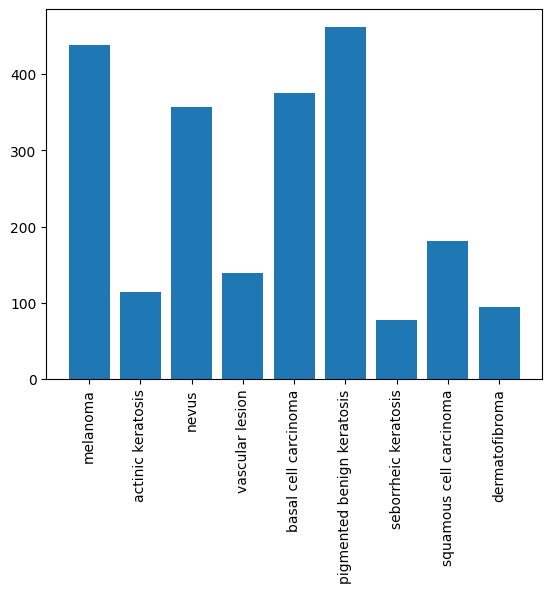

In [ ]:
from sklearn.preprocessing import LabelEncoder
from collections import Counter

#  split into input and out put elements

x,y = df["Path"], df["Label"]

# label encode the target variable
le = LabelEncoder().fit(y)
y = le.transform(y)
y
# summarize distribution
counter = Counter(y)

countDict = dict()
for k,v in counter.items():

  per = v/len(y) * 100
  print("Class=%s, n=%d (%.3f%%)" % (le.classes_[k],v, per))
  countDict[le.classes_[k]] = v

plt.bar(countDict.keys(), countDict.values())
plt.xticks(rotation='vertical')
plt.show()

#### **Todo:** Write your findings here:
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?


pigmented benign keratosis and melanoma  are dominating our data by covering ~20% of our images each.

While classes like seborrheic keratosis and dermatofibroma by less than 5% image form total each are at disadvantage.

lets see if augmenting data mitigate this problem.

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [ ]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [ ]:
import Augmentor
# For some classes
# Every function requires you to specify a probability, which is used to decide if an operation is applied
# to an image as it is passed through the augmentation pipeline
p = Augmentor.Pipeline(data_dir_train)

# Point to a directory containing ground truth data.
# Images with the same file names will be added as ground truth data
# and augmented in parallel to the original data.
p.ground_truth(data_dir_train)

p.rotate(probability=0.9, max_left_rotation=10, max_right_rotation=10)
p.flip_left_right(probability=0.7)
p.flip_top_bottom(probability=0.7)
p.zoom(probability=0.7, min_factor=1.1, max_factor=1.5)

# Augmentor (version >=0.2.1) now uses multi-threading to increase the speed of generating images.
# This may slow down some pipelines if the original images are very small. Set multi_threaded to False if slowdown is experienced:
# However, by default the sample() function uses multi-threading. This is currently only implemented when saving to disk.
# Generators will use multi-threading in the next version update.

p.sample(500, multi_threaded=True) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

# If you wish to process each image in the pipeline exactly once, use process():
# This function might be useful for resizing a dataset for example. It would make sense to create
# a pipeline where all of its operations have their probability set to 1 when using the process() method.
p.process()


Initialised with 2239 image(s) found.
Output directory set to /content/gdrive/MyDrive/upgrad/4.DeepLearning/Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

2239 ground truth image(s) found.


Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x78848C7EFB50>: 100%|██████████| 500/500 [00:17<00:00, 28.83 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78847A199D50>: 100%|██████████| 2239/2239 [01:29<00:00, 25.07 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [ ]:
path_to_training_augmented="/content/gdrive/MyDrive/upgrad/4.DeepLearning/Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output"
from glob import glob
for i in class_names:
  # print(list(glob(os.path.join(data_dir_train,'output', i, '*.jpg'))))
  # glob(os.path.join(data_dir_train, '*','output', '*.jpg'))
  image_count_train = len(list(glob(os.path.join(path_to_training_augmented, i, '*.jpg'))))
  print(i, image_count_train, len(list(glob(os.path.join(data_dir_train, i, '*.jpg')))))

actinic keratosis 284 114
basal cell carcinoma 918 376
dermatofibroma 232 95
melanoma 1066 438
nevus 866 357
pigmented benign keratosis 1118 462
seborrheic keratosis 192 77
squamous cell carcinoma 446 181
vascular lesion 356 139


### Lets see the distribution of augmented data after adding new images to the original training data.

In [ ]:
path_list_new = [x for x in glob(os.path.join(path_to_training_augmented, '*','*.jpg'))]
path_list_new[:10]

['/content/gdrive/MyDrive/upgrad/4.DeepLearning/Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output/actinic keratosis/actinic keratosis_original_ISIC_0033358.jpg_f6389e9d-0e2c-42aa-9d4f-fc3568b6ff0e.jpg',
 '/content/gdrive/MyDrive/upgrad/4.DeepLearning/Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output/actinic keratosis/_groundtruth_(1)_actinic keratosis_ISIC_0033358.jpg_f6389e9d-0e2c-42aa-9d4f-fc3568b6ff0e.jpg',
 '/content/gdrive/MyDrive/upgrad/4.DeepLearning/Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output/actinic keratosis/actinic keratosis_original_ISIC_0027536.jpg_81d83020-0ad2-4b3b-8be5-606201f47b6c.jpg',
 '/content/gdrive/MyDrive/upgrad/4.DeepLearning/Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output/actinic keratosis/_groundtruth_(1)_actinic keratosis_ISIC_0027536

In [ ]:
lesion_list_new = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(path_to_training_augmented, '*', '*.jpg'))]
len(set(lesion_list_new))

9

In [ ]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [ ]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
df2['Label'].value_counts()

pigmented benign keratosis    1118
melanoma                      1066
basal cell carcinoma           918
nevus                          866
squamous cell carcinoma        446
vascular lesion                356
actinic keratosis              284
dermatofibroma                 232
seborrheic keratosis           192
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

Class=actinic keratosis, n=284 (5.184%)
Class=basal cell carcinoma, n=918 (16.758%)
Class=dermatofibroma, n=232 (4.235%)
Class=melanoma, n=1066 (19.460%)
Class=nevus, n=866 (15.809%)
Class=pigmented benign keratosis, n=1118 (20.409%)
Class=seborrheic keratosis, n=192 (3.505%)
Class=squamous cell carcinoma, n=446 (8.142%)
Class=vascular lesion, n=356 (6.499%)


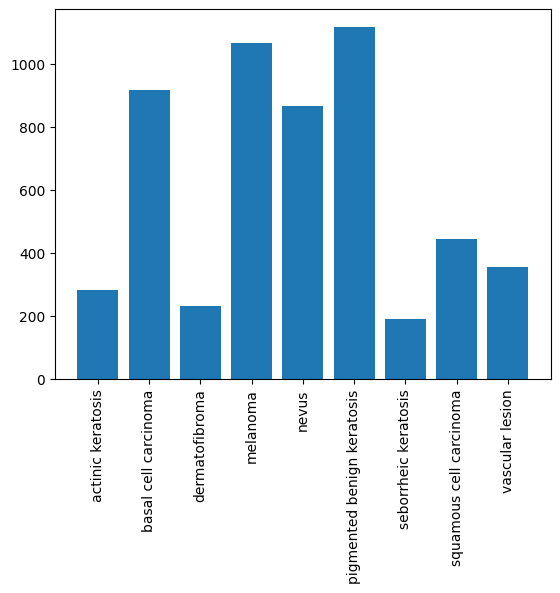

In [ ]:
#  split into input and out put elements

x,y = df2["Path"], df2["Label"]

# label encode the target variable
le = LabelEncoder().fit(y)
y = le.transform(y)
y
# summarize distribution
counter = Counter(y)

countDict = dict()
for k,v in counter.items():

  per = v/len(y) * 100
  print("Class=%s, n=%d (%.3f%%)" % (le.classes_[k],v, per))
  countDict[le.classes_[k]] = v

plt.bar(countDict.keys(), countDict.values())
plt.xticks(rotation='vertical')
plt.show()

after augmentation seborrheic keratosis and dermatofibroma by less than 5% are still under-represented and pigmented benign keratosis and melanoma still dominate our sample numbers by covering ~20% of our data each

pigmented benign keratosis and melanoma  are dominating our data by covering ~20% of our images each.

While classes like seborrheic keratosis and dermatofibroma by less than 5% image form total each are at disadvantage.

lets see if augmenting data mitigate this problem.

adding augmentation to the model pipe seem to be a better strategy for augmentation than generating augmented data and train data based on that, unless augmentation being used for both test and train set.

#### **Todo**: Train the model on the data created using Augmentor data

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  path_to_training_augmented,
  seed=123,
  validation_split = 0.2,
  subset = "training", ## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5478 files belonging to 9 classes.
Using 4383 files for training.


#### **Todo:** Create a validation dataset

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  path_to_training_augmented,
  seed=123,
  validation_split = 0.2,
  subset = "validation", ## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5478 files belonging to 9 classes.
Using 1095 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [ ]:
## your code goes here
num_classes = 9

model = Sequential([layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
                    layers.Conv2D(16, 3, padding="same", activation="relu"),
                    layers.MaxPool2D(),
                    layers.Dropout(0.2),

                    layers.Conv2D(32, 3, padding="same", activation="relu"),
                    layers.MaxPool2D(),
                    layers.Dropout(0.2),

                    layers.Conv2D(64, 3, padding="same", activation="relu"),
                    layers.MaxPool2D(),
                    layers.Dropout(0.2),

                    layers.Flatten(),
                    layers.Dense(128, activation="relu"),

                    layers.Dense(num_classes, activation= "softmax")
                    ])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [ ]:
## your code goes here
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer="adam",
              metrics=['accuracy'])

model.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_21 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_63 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_63 (MaxPooli  (None, 90, 90, 16)        0         
 ng2D)                                                           
                                                                 
 dropout_44 (Dropout)        (None, 90, 90, 16)        0         
                                                                 
 conv2d_64 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_64 (MaxPooli  (None, 45, 45, 32)        0         
 ng2D)                                               

#### **Todo:**  Train your model

In [ ]:
epochs = 50
## Your code goes here, use 50 epochs.
# adding early stoping
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
history = model.fit(
  train_ds,
  validation_data=val_ds,
  batch_size=batch_size,
  epochs=epochs,
  callbacks=[es],
  verbose=1
)

Epoch 1/50
137/137 [==============================] - 14s 86ms/step - loss: 2.0464 - accuracy: 0.2932 - val_loss: 1.7194 - val_accuracy: 0.3635
Epoch 2/50
137/137 [==============================] - 12s 84ms/step - loss: 1.6129 - accuracy: 0.4123 - val_loss: 1.6879 - val_accuracy: 0.3589
Epoch 3/50
137/137 [==============================] - 12s 85ms/step - loss: 1.5248 - accuracy: 0.4431 - val_loss: 1.5248 - val_accuracy: 0.4658
Epoch 4/50
137/137 [==============================] - 12s 84ms/step - loss: 1.4396 - accuracy: 0.4853 - val_loss: 1.3899 - val_accuracy: 0.5205
Epoch 5/50
137/137 [==============================] - 12s 84ms/step - loss: 1.3098 - accuracy: 0.5289 - val_loss: 1.3232 - val_accuracy: 0.5215
Epoch 6/50
137/137 [==============================] - 12s 85ms/step - loss: 1.2108 - accuracy: 0.5610 - val_loss: 1.2313 - val_accuracy: 0.5635
Epoch 7/50
137/137 [==============================] - 12s 84ms/step - loss: 1.1279 - accuracy: 0.5959 - val_loss: 1.1975 - val_accuracy:

#### **Todo:**  Visualize the model results

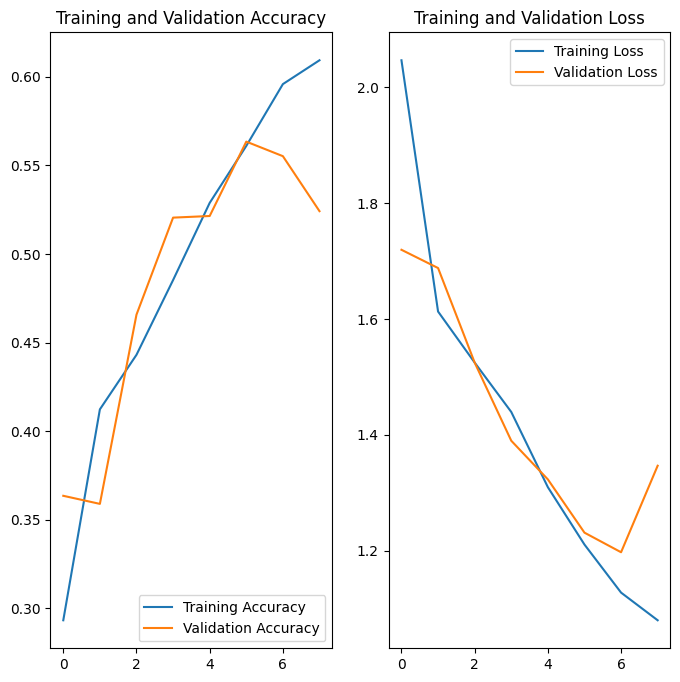

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(8)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

the model perform very well when the train and test are selected from augmented data and stoped at 8 epocs with very low difference between the result for training and validation set

## **Generate model based on augmented training set and test it on test set**

#### **Todo**: Train the model on the data created using Augmentor data for training and testing on unseen data

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [ ]:
# data_dir_train="path to directory with training data + data created using augmentor"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  path_to_training_augmented,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5478 files belonging to 9 classes.


#### **Todo:** Create a validation dataset

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_test,
  seed=123,
  # validation_split = 0,
  # subset = "validation", ## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 118 files belonging to 9 classes.


#### **Todo:** Create your model (make sure to include normalization)

In [ ]:
## your code goes here
num_classes = 9

model = Sequential([layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
                    layers.Conv2D(16, 3, padding="same", activation="relu"),
                    layers.MaxPool2D(),
                    layers.Dropout(0.2),

                    layers.Conv2D(32, 3, padding="same", activation="relu"),
                    layers.MaxPool2D(),
                    layers.Dropout(0.2),

                    layers.Conv2D(64, 3, padding="same", activation="relu"),
                    layers.MaxPool2D(),
                    layers.Dropout(0.2),

                    layers.Flatten(),
                    layers.Dense(128, activation="relu"),

                    layers.Dense(num_classes, activation= "softmax")
                    ])


#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [ ]:
## your code goes here
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer="adam",
              metrics=['accuracy'])

model.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_25 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_75 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_75 (MaxPooli  (None, 90, 90, 16)        0         
 ng2D)                                                           
                                                                 
 dropout_56 (Dropout)        (None, 90, 90, 16)        0         
                                                                 
 conv2d_76 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_76 (MaxPooli  (None, 45, 45, 32)        0         
 ng2D)                                               

#### **Todo:**  Train your model

In [ ]:
epochs = 50
## Your code goes here, use 50 epochs.
# adding early stopping did not work since it stoped at 3
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
history = model.fit(
  train_ds,
  validation_data=val_ds,
  batch_size=batch_size,
  epochs=epochs,
  # callbacks=[es],
  verbose=1
)

Epoch 1/50
172/172 [==============================] - 17s 80ms/step - loss: 2.0177 - accuracy: 0.2817 - val_loss: 2.0755 - val_accuracy: 0.3051
Epoch 2/50
172/172 [==============================] - 14s 80ms/step - loss: 1.5908 - accuracy: 0.4310 - val_loss: 1.9189 - val_accuracy: 0.3051
Epoch 3/50
172/172 [==============================] - 14s 80ms/step - loss: 1.3749 - accuracy: 0.5080 - val_loss: 2.0437 - val_accuracy: 0.3220
Epoch 4/50
172/172 [==============================] - 14s 80ms/step - loss: 1.2702 - accuracy: 0.5440 - val_loss: 2.4640 - val_accuracy: 0.2966
Epoch 5/50
172/172 [==============================] - 14s 81ms/step - loss: 1.1891 - accuracy: 0.5655 - val_loss: 2.3903 - val_accuracy: 0.2881
Epoch 6/50
172/172 [==============================] - 15s 84ms/step - loss: 1.1321 - accuracy: 0.5865 - val_loss: 2.4830 - val_accuracy: 0.3644
Epoch 7/50
172/172 [==============================] - 15s 83ms/step - loss: 1.0049 - accuracy: 0.6322 - val_loss: 3.0772 - val_accuracy:

#### **Todo:**  Visualize the model results

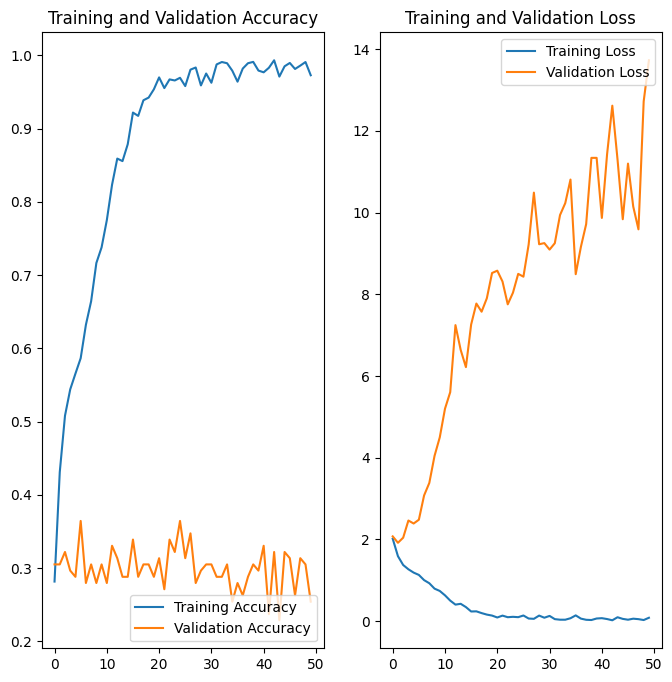

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

adding very large number of augmented data dramatically improved the model performances for training set to the level of overfitting. but no improvement on test set. So the model that is trained on augmented data is performing poorly to unseen data that was not used for augmentation.

## **Add extra layer to model for large augmented data**

#### **Todo**: Train the model on the data created using Augmentor data

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  path_to_training_augmented,
  seed=123,
  validation_split = 0.2,
  subset = "training", ## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5478 files belonging to 9 classes.
Using 4383 files for training.


#### **Todo:** Create a validation dataset

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  path_to_training_augmented,
  seed=123,
  validation_split = 0.2,
  subset = "validation", ## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5478 files belonging to 9 classes.
Using 1095 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [ ]:
## your code goes here
num_classes = 9

model = Sequential([layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
                    layers.Conv2D(16, 3, padding="same", activation="relu"),
                    layers.MaxPool2D(),
                    layers.Dropout(0.2),

                    layers.Conv2D(32, 3, padding="same", activation="relu"),
                    layers.MaxPool2D(),
                    layers.Dropout(0.2),

                    layers.Conv2D(64, 3, padding="same", activation="relu"),
                    layers.MaxPool2D(),
                    layers.Dropout(0.2),

                    layers.Conv2D(64, 3, padding="same", activation="relu"),
                    layers.MaxPool2D(),
                    layers.Dropout(0.2),

                    layers.Flatten(),
                    layers.Dense(128, activation="relu"),

                    layers.Dense(num_classes, activation= "softmax")
                    ])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [ ]:
## your code goes here
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer="adam",
              metrics=['accuracy'])

model.summary()

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_30 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_94 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_94 (MaxPooli  (None, 90, 90, 16)        0         
 ng2D)                                                           
                                                                 
 dropout_75 (Dropout)        (None, 90, 90, 16)        0         
                                                                 
 conv2d_95 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_95 (MaxPooli  (None, 45, 45, 32)        0         
 ng2D)                                               

#### **Todo:**  Train your model

In [ ]:
epochs = 50
## Your code goes here, use 50 epochs.
# adding early stoping did not generate enoufgh epocs to plot
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
history = model.fit(
  train_ds,
  validation_data=val_ds,
  batch_size=batch_size,
  epochs=epochs,
  callbacks=[es],
  verbose=1
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


137/137 [==============================] - 14s 85ms/step - loss: 1.9373 - accuracy: 0.2608 - val_loss: 1.7696 - val_accuracy: 0.3826
Epoch 2/50
137/137 [==============================] - 12s 85ms/step - loss: 1.6380 - accuracy: 0.4127 - val_loss: 1.5924 - val_accuracy: 0.4192
Epoch 3/50
137/137 [==============================] - 12s 85ms/step - loss: 1.5013 - accuracy: 0.4570 - val_loss: 1.5482 - val_accuracy: 0.4868
Epoch 4/50
137/137 [==============================] - 12s 84ms/step - loss: 1.3988 - accuracy: 0.5029 - val_loss: 1.3605 - val_accuracy: 0.5151
Epoch 5/50
137/137 [==============================] - 12s 85ms/step - loss: 1.3506 - accuracy: 0.5159 - val_loss: 1.3266 - val_accuracy: 0.4950
Epoch 6/50
137/137 [==============================] - 12s 84ms/step - loss: 1.2167 - accuracy: 0.5626 - val_loss: 1.3354 - val_accuracy: 0.4986
Epoch 6: early stopping


#### **Todo:**  Visualize the model results

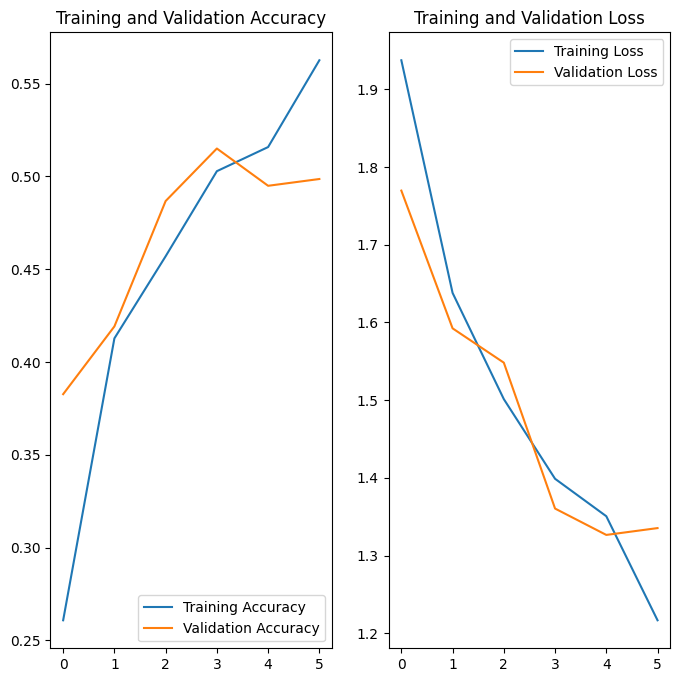

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(6)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

when we add more layers to the model trained for augmented data

the model performance reduced in comparison with previous version when the train and test are selected from augmented data and stoped at 6 epocs with very low difference between the result for training and validation set

## **Generate model based on augmented training set and test it on test set**

#### **Todo**: Train the model on the data created using Augmentor data for training and testing on unseen data

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [ ]:
# data_dir_train="path to directory with training data + data created using augmentor"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  path_to_training_augmented,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5478 files belonging to 9 classes.


#### **Todo:** Create a validation dataset

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_test,
  seed=123,
  # validation_split = 0,
  # subset = "validation", ## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 118 files belonging to 9 classes.


#### **Todo:** Create your model (make sure to include normalization)

In [ ]:
## your code goes here
num_classes = 9

model = Sequential([layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
                    layers.Conv2D(16, 3, padding="same", activation="relu"),
                    layers.MaxPool2D(),
                    layers.Dropout(0.2),

                    layers.Conv2D(32, 3, padding="same", activation="relu"),
                    layers.MaxPool2D(),
                    layers.Dropout(0.2),

                    layers.Conv2D(64, 3, padding="same", activation="relu"),
                    layers.MaxPool2D(),
                    layers.Dropout(0.2),

                    layers.Conv2D(64, 3, padding="same", activation="relu"),
                    layers.MaxPool2D(),
                    layers.Dropout(0.2),

                    layers.Conv2D(64, 3, padding="same", activation="relu"),
                    layers.MaxPool2D(),
                    layers.Dropout(0.2),

                    layers.Flatten(),
                    layers.Dense(128, activation="relu"),

                    layers.Dense(num_classes, activation= "softmax")
                    ])


#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [ ]:
## your code goes here
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer="adam",
              metrics=['accuracy'])

model.summary()

Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_31 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_98 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_98 (MaxPooli  (None, 90, 90, 16)        0         
 ng2D)                                                           
                                                                 
 dropout_79 (Dropout)        (None, 90, 90, 16)        0         
                                                                 
 conv2d_99 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_99 (MaxPooli  (None, 45, 45, 32)        0         
 ng2D)                                               

#### **Todo:**  Train your model

In [ ]:
epochs = 50
## Your code goes here, use 50 epochs.
# adding early stopping did not work since it stoped at 3
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
history = model.fit(
  train_ds,
  validation_data=val_ds,
  batch_size=batch_size,
  epochs=epochs,
  # callbacks=[es],
  verbose=1
)

Epoch 1/50
172/172 [==============================] - 18s 81ms/step - loss: 1.8901 - accuracy: 0.2851 - val_loss: 2.0725 - val_accuracy: 0.2712
Epoch 2/50
172/172 [==============================] - 14s 81ms/step - loss: 1.6319 - accuracy: 0.4138 - val_loss: 2.0362 - val_accuracy: 0.2712
Epoch 3/50
172/172 [==============================] - 15s 81ms/step - loss: 1.5348 - accuracy: 0.4407 - val_loss: 2.1467 - val_accuracy: 0.2712
Epoch 4/50
172/172 [==============================] - 15s 82ms/step - loss: 1.4125 - accuracy: 0.4991 - val_loss: 2.2688 - val_accuracy: 0.2119
Epoch 5/50
172/172 [==============================] - 14s 80ms/step - loss: 1.3587 - accuracy: 0.5254 - val_loss: 2.2998 - val_accuracy: 0.2203
Epoch 6/50
172/172 [==============================] - 14s 79ms/step - loss: 1.3014 - accuracy: 0.5361 - val_loss: 2.5034 - val_accuracy: 0.2203
Epoch 7/50
172/172 [==============================] - 14s 80ms/step - loss: 1.2143 - accuracy: 0.5670 - val_loss: 2.8129 - val_accuracy:

#### **Todo:**  Visualize the model results

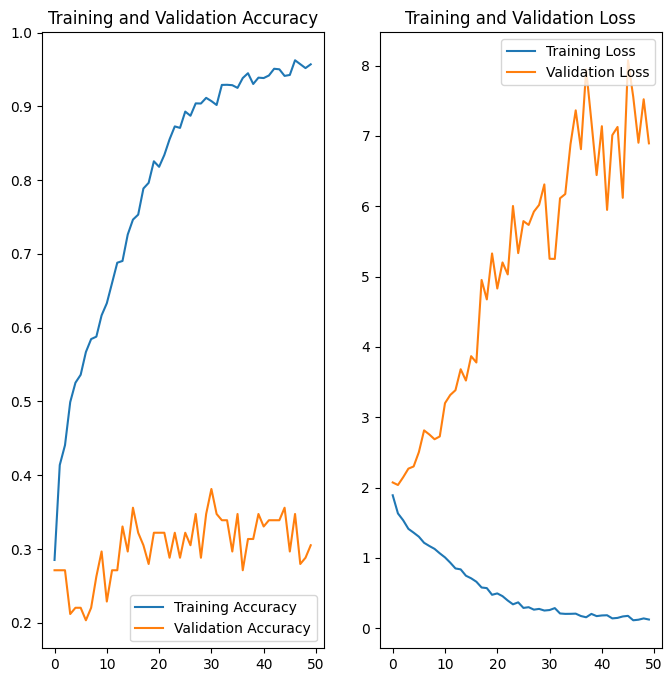

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

adding an extra layer didnot have that mush of effect on model performance when augmented data being used.

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



So far the best model I have identified was the one with three convolutional layer and a dropout after each maxpooling for augmented dqata when test and train are being selected fro augmented data.

I have also observed that adding augmentation to the model development pipe instead of generating augmented data and feeding it to the data frame reduces potential overfitting.

one reason for the failour of augmented data can be the sample number. Some of the classes do not have eanogh data to generate 500 different verssion of an image to be added to our data. So they still stay under represented since those that have actually enough data will generated more samples to be added to original data.